In [36]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.3.0'

In [37]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

Realizando o carregamento da base de dados:

In [3]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Vamos agora a descompactação do arquivo `.zip`:

In [38]:
path = '/content/drive/My Drive/trainingandtestdata.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

Clicando em `test.csv`nós podemos notar que há um erro com as colunas
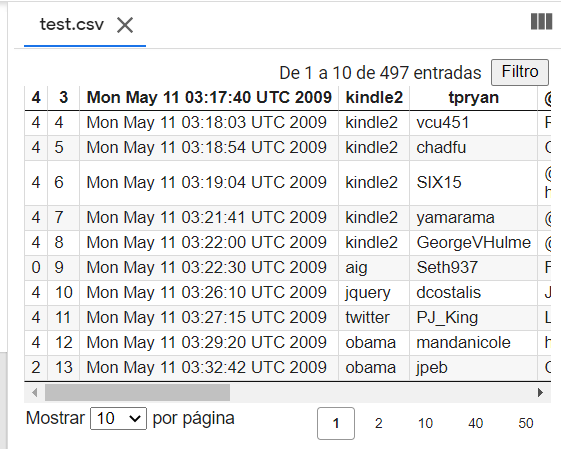

Para tirar esse erro, nós vamos criar um novo código e arrumar isso.

In [39]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [40]:
train = pd.read_csv('/content/trainingandtestdata/train.csv', header = None, names = cols, engine = 'python', encoding = 'latin1')
test = pd.read_csv('/content/trainingandtestdata/test.csv', header = None, names = cols, engine = 'python', encoding = 'latin1')

Vamos dar uma olhada em quantos *tweets* nós temos para fazer a classificação:

In [41]:
train.shape , test.shape

((1600000, 6), (498, 6))

In [8]:
train

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


Nós temos um total de 1.600.000 de *tweets*. Em `sentiment`se vê os números `0`e `4` que indicam se a classe é negativa ou positiva. Vizualizando agora o total de sentimentos positivos e negativos nós temos nessa bade de dados:

In [9]:
train.sentiment.unique()

array([0, 4])

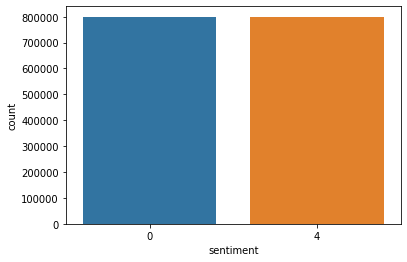

In [10]:
sns.countplot(train.sentiment);

Podemos ver que são quantidades iguais, eles estão balanceados e não será necessário codificações quanto a isso. Vamos ver agora a quantidade de sentimentos que nós temos em `test`:

In [11]:
test.sentiment.unique()

array([4, 0, 2])

Opa! Aqui já temos três classificações diferentes de sentimentos. Aqui nos é apresentado o sentimento neutro.

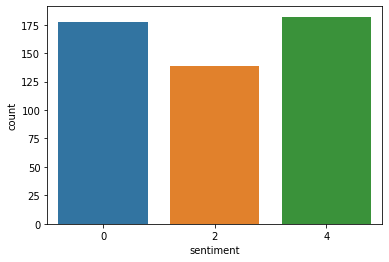

In [12]:
sns.countplot(test.sentiment);

Assim como em `train`os classificadores `0`e `4` estão distribuídos igualemente mas não podemos dizer o mesmo do `2`, que apresenta-se em uma quantidade menor.

Como vamos usar somente as colunas `sentiment`e `text`iremos realizar a exclusão das demais colunas

In [42]:
data = train
data.drop(['id', 'date', 'query', 'user'], axis = 1, inplace = True)
data

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


Vamos seprar agora os atributo previsor: `text`e o classificador: `sentiment`e para isso iremos criar uma variável para armazená-los.

In [43]:
X = data.iloc[:, 1].values
X

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [44]:
Y = data.iloc[:, 0].values
Y

array([0, 0, 0, ..., 4, 4, 4])

O `train` tem muitos registros, por isso iremos diminuir a quantidade de registros para facilitar o treinamento. Vamos trabalhar somente com 50% dos *tweets*

In [45]:
from sklearn.model_selection import train_test_split
X, _, Y, _ = train_test_split(X, Y, test_size = 0.5, stratify = Y)

Vamos agora realizar a limpeza dos textos:

In [46]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [47]:
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
text = clean_tweets(text)
text

' Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

Agora a remoção das stopwords:

In [48]:
nlp = sp.load('en')
stop_words = sp.lang.en.STOP_WORDS
print(stop_words)

{'mine', 'them', 'were', 'on', 'now', 'keep', 'move', 'by', 'take', 'her', 'out', '‘ll', 'in', 'neither', 'seemed', 'toward', "'d", 'whose', 'below', 'already', 'perhaps', 'into', 'ever', 'been', 'eleven', 'enough', 'five', 'few', 'has', 'how', 'seems', 'would', 'via', 'a', 'at', 'us', 'thereupon', 'whereupon', 'quite', 'any', 'beside', 'ten', 'n‘t', 'thereby', '’d', 'again', 'up', 'well', 'others', 'sixty', 'or', 'was', 'behind', 'hence', 'once', 'still', 'thru', 'per', 'whereby', 'formerly', 'therein', 'where', 'hereby', "'ll", "'re", 'without', '’re', 'one', 'before', 'give', 'those', 'had', 'eight', 'whenever', 'whence', '‘s', 'sometime', 'might', 'everyone', 'do', 'former', 'full', 'anyone', 'me', 'four', 'therefore', 'please', 'anything', 'more', 'wherein', 'front', 'several', 'used', 'down', 'could', 'each', 'various', 'beforehand', 'itself', 'hers', 'same', 'made', 'this', 'mostly', 'nor', 'between', 'always', 'our', 'seeming', 'through', 'back', 'elsewhere', 'empty', 'never', 

Agora que temos as `stop_words`, podemos tirá-las do textos e deixá-los ainda mais limpos e logo vamos criar a variável `text2` para poder ver como ficou o texto exemplo depois da remoção das `stop_words`.

In [49]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)
  words = []
  for token in document:
    words.append(token.text)
  
  #words = [word for word in words if word not in stop_words]
  words = ' '.join([str(element) for element in words])
  
  return words

In [50]:
text2 = clean_tweets2(text)
text2

'  awww that s a bummer . you shoulda got david carr of third day to do it . d'

Como vimos, a limpeza de dados foi feita e agora é necessário passar esses parâmetros para toda base de dados:

In [51]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]
#visualizando como ficou alguns desses textos:
for _ in range(15):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

  it doesn t look like it he s played the last years so he s probably giving it a miss this time . hopefully next year though .
.... idk i wanna do sumthin crazy any ideas ? ?
  u beta x hold this against me lke the rest of my embarasing stuff or i will take it back sincere but insincere smile
today i will be rider really would be betterer with a supporters ...
  idk !
  nope ! infact i feel better ! aha
ahh i m going crazy . so bored . i don t know what to do
o yea if you typing me in spanish .lol ur killing me i don t read spanish i try but i can t google translate every message
  only people who follow you can see that . perhaps you could ask your followers to tweet about following you . i d do it
irs r initial reaction seems like good news for us
  sittin here bein bored outta my mind ... god if i could only go to toronto tonight i might be happy
i m hungry is ok if i eat jicama ? haha with salsa and spicy ? jaja is late but i really wanna eat that
  i need somethin to bump too i l

Vou criar a variavel `data_labels` para poder armazenar os dados qye estão em `Y`e assim poder alterar as respostas para `1`e `0`já que será usada a função sigmóide e ela trabalha com probabilidades.

In [52]:
data_labels = Y
data_labels[data_labels == 4] = 1
data_labels

array([1, 1, 0, ..., 0, 1, 1])

**Tranformação das palavras em números:**

Estamos trabalhando com *tweets* em inglês e na lingua inglesa se tem pouco mais de 170.000 palavras, porém no cotidiano só é usada pouco mais de 20.000 sendo umas 3.000 no dia. Então não será necessário ter um grande vocabulário nesse nosso próximo código

In [53]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16) #2**16 = 65536, que será o número máximo de palavras
tokenizer.vocab_size #visualizando a quantidade de vocábulos

68435

Realizado a tokenização, podemos visualizar o id de cada palavra, vejamos algusn exemplos:

In [54]:
ids = tokenizer.encode('i am happy')
ids2 = tokenizer.encode('i am sad')
ids, ids2

([1, 60, 595], [1, 60, 252])

E agora para verificar se o nosso tokenizador está funcionando corretamente, iremos fazer o processo contrário:

In [55]:
text = tokenizer.decode(ids)
text2 = tokenizer.decode(ids2)
text, text2

('i am happy', 'i am sad')

A variável `data_inputs`será criada para transformar todos os *tweets* em números e logo em seguida vamos visulizar uma parte dos textos agora em númeoros:

In [56]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]
for _ in range(5):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[27, 1617, 7, 2451, 4, 46, 6, 18433, 58, 9748, 109, 6, 527, 13518, 1246, 9, 44226, 68290, 9, 93, 21, 42, 1, 98, 3, 43, 13, 3, 49, 210, 3, 20988]
[1516, 30340, 649, 1713, 479, 163]
[1, 110, 568, 47, 20, 6267]
[2, 32, 145, 247]
[525, 5, 15315, 61, 9798, 1461, 1, 110, 327, 471, 196]


Como visto nos exemplos anteriores, há frases com mais palavras que outras, para deixá-las no mesmo tamanho será feito o `padding`que significa preenchimento.

In [57]:
max_len = max([len(sentence) for sentence in data_inputs]) #pega o valor máximo de sentença
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs, value = 0, padding = 'post', maxlen = max_len) #post mantem a ordem da esquerda para direita

for _ in range(5):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[    2   170     8     1 18960    61    45  6810     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]
[    1  1235     6 24991   380 18518     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]
[   46  2844    47    20     7   903    99   126    33  5699     8   221
     3     6  3066   244    16    23   646    21 

Vamos dividir a base de dados para treinamento e teste e logo em seguida construir a rede neural:

In [58]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs, data_labels, test_size=0.3, stratify = data_labels)

In [59]:
class DCNN(tf.keras.Model):

  def __init__(self, vocab_size, emb_dim=128, nb_filters=50, ffn_units=512, nb_classes=2, dropout_rate=0.1, training=True, name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters = nb_filters, kernel_size = 2, padding ='same', activation ='relu')

    self.trigram = layers.Conv1D(filters = nb_filters, kernel_size = 3, padding = 'same', activation = 'relu')

    self.fourgram = layers.Conv1D(filters = nb_filters, kernel_size = 4, padding = 'same', activation = 'relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) #(batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

Vamos agora configurar alguns parametros e logo em seguida realizar o treinamneto do modelo.

In [60]:
#parametros:
vocab_size = tokenizer.vocab_size
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
dropout_rate = 0.2
nb_epochs = 5

In [61]:
#treinamento:
DCNN = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters, ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

if nb_classes == 2:
  DCNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  DCNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
#como demora de fazer o treinamento, aqui é feito um checkpoitn para ficar salvo
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=DCNN)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [63]:
history = DCNN.fit(train_inputs, train_labels, batch_size = batch_size, epochs = nb_epochs, verbose = 1, validation_split = 0.10)
ckpt_manager.save()

Epoch 1/5
7875/7875 [==============================] - 2206s 280ms/step - loss: 0.4222 - accuracy: 0.8047 - val_loss: 0.3898 - val_accuracy: 0.8251
Epoch 2/5
7875/7875 [==============================] - 2202s 280ms/step - loss: 0.3194 - accuracy: 0.8616 - val_loss: 0.3983 - val_accuracy: 0.8230
Epoch 3/5
7875/7875 [==============================] - 2190s 278ms/step - loss: 0.2128 - accuracy: 0.9130 - val_loss: 0.4928 - val_accuracy: 0.8085
Epoch 4/5
7875/7875 [==============================] - 2192s 278ms/step - loss: 0.1360 - accuracy: 0.9457 - val_loss: 0.6308 - val_accuracy: 0.7954
Epoch 5/5
7875/7875 [==============================] - 2193s 279ms/step - loss: 0.0952 - accuracy: 0.9622 - val_loss: 0.7771 - val_accuracy: 0.7920


'./ckpt-1'

**Vamos agora para as avaliação do modelo e previsões:**

In [64]:
#avaliação:
results = DCNN.evaluate(test_inputs, test_labels, batch_size = batch_size)
print(results)

3750/3750 [==============================] - 152s 40ms/step - loss: 0.7823 - accuracy: 0.7905
[0.7823459506034851, 0.7905208468437195]


Vamos fazer uma previsão onde nos retornará `False`para quando for *menor de `0.5`* e indica que é sentimento **negativo**. `True` quando for *maior do que `0.5`* e indica que o sentimento é **positivo**.

In [65]:
pred = DCNN.predict(test_inputs)
pred = (pred > 0.5)
pred

array([[ True],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [66]:
from sklearn.metrics import accuracy_score
acerto = accuracy_score(test_labels, pred)
erro = 1 - acerto
acerto, erro

(0.7905208333333333, 0.20947916666666666)

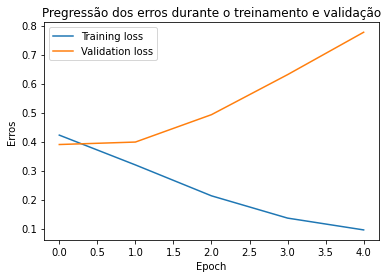

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pregressão dos erros durante o treinamento e validação')
plt.xlabel('Epoch')
plt.ylabel('Erros')
plt.legend(['Training loss', 'Validation loss'])

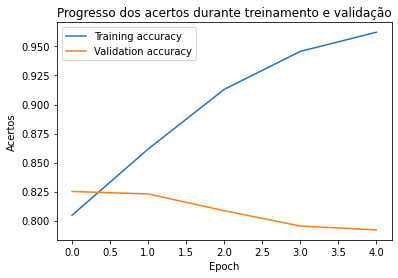

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Progresso dos acertos durante treinamento e validação')
plt.xlabel('Epoch')
plt.ylabel('Acertos')
plt.legend(['Training accuracy', 'Validation accuracy'])

Previsoes: qaunto mais próximo de um, o sentimento é **positivo**, se próximo de 0 ele é um sentimento **negativo**.

In [69]:
test.iloc[:, 5].values
#test

array(['@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.',
       'Reading my kindle2...  Love it... Lee childs is good read.',
       'Ok, first assesment of the #kindle2 ...it fucking rocks!!!',
       "@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)",
       "@mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)",
       "@richardebaker no. it is too big. I'm quite happy with the Kindle2.",
       'Fuck this economy. I hate aig and their non loan given asses.',
       'Jquery is my new best friend.', 'Loves twitter',
       'how can you not love Obama? he makes jokes about himself.',
       "Check this video out -- President Obama at the White House Correspondents' Dinner http://bit.ly/IMXUM",
       "@Karoli I firmly believe that Obama/Pelosi have ZERO desire to be civil.  It's a charade and a slogan, but t

In [70]:
text1 = 'i do not like you'
text1 = tokenizer.encode(text1)
text1

[1, 43, 32, 41, 85]

In [71]:
DCNN(np.array([text1]), training=False).numpy()

array([[0.07368672]], dtype=float32)

Ele acertou! "I do not like you" é um sentimento negativo!

In [72]:
text2 = 'i really love you'
text2 = tokenizer.encode(text2)
text2

[1, 67, 53, 85]

In [73]:
DCNN(np.array([text2]), training=False).numpy()

array([[0.85162824]], dtype=float32)

Mais um acerto! "I really love you" é um sentimento positivo

In [74]:
text3 = '7 hours. 7 hours of inkscape crashing, normally solid as a rock. 7 hours of LaTeX complaining at the slightest thing. I can t take any more.'
text3 = tokenizer.encode(text3)

In [75]:
DCNN(np.array([text3]), training=False).numpy()

array([[0.01815456]], dtype=float32)

Aqui ele já mostra uma classificação próxima do zero, indicando um sentimento negativo. Acertou!! É uma frase retirada do `test`e é bem grande!

In [76]:
text4 = 'Excited about seeing Bobby Flay and Guy Fieri tomorrow at the Great American Food &amp; Music Fest!'
text4 = tokenizer.encode(text4)

In [77]:
DCNN(np.array([text4]), training=False).numpy()

array([[0.8387933]], dtype=float32)

Nesse exemplo retirado em um dos *tweets* ele já consegue ter mais certeza sobre ser um sentimento positivo... E acertou!!